# Text Mining Unit Exercises

**Text Classification and Sentiment Analysis**

_Prof. Gianluca Moro, Dott. Ing. Nicola Piscaglia – DISI, University of Bologna_

**Bologna Business School** - Alma Mater Studiorum Università di Bologna

## Instructions

- The provided exercises must be executed by teams up to 4 students

- It is allowed to consult course material and the Web for advice

- If still in doubt about anything, ask the teacher

- At the end, the file must contain all the required results (as code cell outputs) along with all the commands necessary to reproduce them

- The function of every command or group of related commands
must be documented clearly and concisely. 

- You have 1 hour to complete the test.

## Setup

The following cell contains all necessary imports

In [ ]:
import numpy as np
import pandas as pd
import gzip
import json
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from urllib.request import urlretrieve

Run the following to download the necessary files

In [ ]:
def download(file, url):
    if not os.path.exists(file):
        urlretrieve(url, file)

In [ ]:
download("Magazine_Subscriptions.json.gz", "https://www.dropbox.com/s/g6om8q8c8pvirw8/Magazine_Subscriptions.json.gz?dl=1")

In [ ]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Dataset

We provide in the `Magazine_Subscriptions.json.gz` file a dataset of 89,689 reviews posted on Amazon.com about Magazine Subscriptions.

Afterwards the dataset loading, we undersample the data to 26115 reviews in order to provide you with a class balanced dataset.

Each review is labeled with a score between 1 and 5 stars (represented by the ```overall``` feature).

The text of each review is represented by the ```reviewText``` feature which is going to be our input data along with the ```overall``` one.





Run the following to correctly load the file into a pandas DataFrame.

In [ ]:
def parse(path):
  gzip_file = gzip.open(path, 'rb')
  for file_line in gzip_file:
    yield json.loads(file_line)

def getDF(path):
  index = 0
  df = {}
  for entry in parse(path):
    df[index] = entry
    index += 1
  return pd.DataFrame.from_dict(df, orient='index')

data = getDF('Magazine_Subscriptions.json.gz')

In [ ]:
rus = RandomUnderSampler(random_state=42)
data, _ = rus.fit_resample(data, data["overall"])

In [ ]:
# Cast the review text type in order to be able to use it with sklearn later
data["reviewText"] = data["reviewText"].values.astype('U')

In [ ]:
data.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,1.0,22,False,"08 14, 2007",A2P7ETBL7020DF,B000O1PKOG,Gary Smith,This magazine has a catchy title and very nice...,Just plain lame.,1187049600,{'Format:': ' Print Magazine'},NaN
1,1.0,3,False,"01 9, 2014",AONC3Q7956CQ6,B00005N7T5,J-Lick,Before it was easy to go directly to the New Y...,Very Dissapointed in the on line format,1389225600,{'Format:': ' Kindle Edition'},NaN
2,1.0,11,False,"09 7, 2009",A9004RLMUCQCJ,B00077B7M6,PT,I don't really understand why this product is ...,Extremely Expensive,1252281600,{'Format:': ' Kindle Edition'},NaN
3,1.0,NaN,False,"10 9, 2015",A1DEYML4ZKN1WV,B00HG1BP0U,Angie,Looked nicer in the picture,One Star,1444348800,{'Format:': ' Print Magazine'},NaN
4,1.0,NaN,True,"07 23, 2014",A3ULPJ814I5LP6,B000IOEK7M,John,Never received.,One Star,1406073600,NaN,NaN


In [ ]:
data.index.size

26115

## Exercises

**1)** Select from data only the features named ```reviewText``` and ```overall``` putting them in a dataframe





In [ ]:
data = data[["reviewText", "overall"]]

**2)** Verify the distribution of the number of stars

In [ ]:
data["overall"].value_counts()

1.0    5223
2.0    5223
3.0    5223
4.0    5223
5.0    5223
Name: overall, dtype: int64

**3)** Remove from data the reviews rated with 3 stars.

In [ ]:
data = data[data["overall"] != 3]

**4)** Add a `label` column to the DataFrame whose value is `"pos"` for reviews with 4 stars, `"very_pos"` for 5-rated reviews, `"neg"` for reviews with 2 stars and `"very_neg"` for 1-rated reviews.

In [ ]:
def mapToLabel(value):
  if value == 1:
    return "very_neg"
  elif value == 2:
    return "neg"
  elif value == 4:
    return "pos"
  elif value == 5:
    return "very_pos"

In [ ]:
data["label"] = data["overall"].apply(mapToLabel)

data.head() # To visualize the new dataframe

,reviewText,overall,label
0,This magazine has a catchy title and very nice...,1.0,very_neg
1,Before it was easy to go directly to the New Y...,1.0,very_neg
2,I don't really understand why this product is ...,1.0,very_neg
3,Looked nicer in the picture,1.0,very_neg
4,Never received.,1.0,very_neg


**5)** Split the dataset randomly into a training set with 80% of data and a test set with the remaining 20%, stratifying the split by the `label` variable

In [ ]:
y = data["label"]
X = data["reviewText"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("training set shape: " + str(X_train.shape))
print("Test set shape: " + str(X_test.shape))

training set shape: (16713,)
Test set shape: (4179,)


In [ ]:
y_train.value_counts()

pos         4179
neg         4178
very_neg    4178
very_pos    4178
Name: label, dtype: int64

In [ ]:
y_test.value_counts()

very_neg    1045
very_pos    1045
neg         1045
pos         1044
Name: label, dtype: int64

**6)** Create a tf.idf vector space model from training reviews excluding words appearing in less than 3 documents and using bigrams in addition to single words. Then, extract the document-term matrix for them.

In [ ]:
vect = TfidfVectorizer(min_df=3, ngram_range=(1,2))
train_dtm = vect.fit_transform(X_train)

**7)** Train a logistic regression classifier on the training reviews, using the representation created above

In [ ]:
%%time
model = LogisticRegression(max_iter=500)
model.fit(train_dtm, y_train);

CPU times: user 23.5 s, sys: 1min 13s, total: 1min 36s
Wall time: 53.5 s


**8)** Verify the accuracy of the classifier on the test set

In [ ]:
test_dtm = vect.transform(X_test)
model.score(test_dtm, y_test)

0.6042115338597751

**9)** Print the confusion matrix

In [ ]:
y_pred = model.predict(test_dtm)

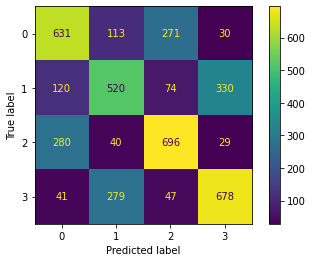

In [ ]:
calculated_confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_display = ConfusionMatrixDisplay(calculated_confusion_matrix)
confusion_matrix_display.plot()